In [8]:
%load_ext autoreload
%autoreload 2
import argparse
from typing import Dict

import torch
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from model.metrics import Metrics
from model.unet import Unet, DEFAULT_UNET_LAYERS
from model.dice_loss import DiceLoss, DiceBCELoss
from datasets.dataset import RetinaSegmentationDataset
from utils.resultPrinter import ResultPrinter
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def train_model(model, dataloader, criterion, optimizer, device, freeze_encoder=True):
    metrics_tracker = Metrics(device)
    model.train()
    if freeze_encoder:
        model.encoder.eval()
    train_running_loss = 0.0
    for ind, (img, lbl) in enumerate(tqdm(dataloader, desc="Training")):
        # Copy to device
        img = img.to(device)
        lbl = lbl.to(device)
        # Make the prediction
        lbl_pred = model(img)
        optimizer.zero_grad()
        # Compute loss
        loss = criterion(lbl_pred, lbl)
        # compute metrics
        metrics_tracker.calculate(lbl_pred, lbl)
        # Running tally
        train_running_loss += loss.item() * img.shape[0]
        # Backward step
        loss.backward()
        optimizer.step()

    # Compute the loss for this epoch
    train_loss = train_running_loss / (ind + 1)
    # Compute the metrics for this epoch
    metrics = metrics_tracker.get_mean_metrics(ind + 1)
    metrics['loss'] = train_loss
    return metrics

In [10]:
def eval_model(model, dataloader, criterion, device):
    metrics_tracker = Metrics(device)
    model.eval()
    eval_running_loss = 0.0
    with torch.no_grad():
        for ind, (img, lbl) in enumerate(tqdm(dataloader, desc="Validation")):
            # Copy to device
            img = img.to(device)
            lbl = lbl.to(device)
            # Make the prediction
            lbl_pred = model(img)
            # Compute loss
            loss = criterion(lbl_pred, lbl)
            # compute metrics
            metrics_tracker.calculate(lbl_pred, lbl)
            # Running tally
            eval_running_loss += loss.item() * img.shape[0]

    # Compute the loss for this epoch
    eval_loss = eval_running_loss / (ind + 1)
    # Compute the metrics for this epoch
    metrics = metrics_tracker.get_mean_metrics(ind + 1)
    metrics['loss'] = eval_loss
    return metrics

In [11]:
def create_model(args, load_encoder_weights: str = None, load_bt_checkpoint: str = None, freeze_encoder = True, seed = 33):
    torch.manual_seed(seed)
    rootdir: str = "C:/Users/shawn/Desktop/Development/CS7643/data/DATA_4D_Patches/DATA_4D_Patches"
    workers: int = 16
    anneal_tmax: int = 10
    anneal_eta: int = 0
    run_name: str = "test-drive"
    checkpoint_dir: str = "C:/Users/shawn/Desktop/Development/CS7643/checkpoint/"

    # Get the device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Determine the layer sizes of the U-Net
    unet_layers = DEFAULT_UNET_LAYERS
    if args["unet_layers"]:
        unet_layers = [int(x) for x in args["unet_layers"].split("-")]

    # Initialize the model on the GPU
    model = Unet(dropout=args["dropout"], hidden_channels=unet_layers).to(device)
    if load_encoder_weights:
        model.encoder.load_state_dict(torch.load(load_encoder_weights)["encoder"])
    elif load_bt_checkpoint:
        model.encoder.load_state_dict(torch.load(load_bt_checkpoint)["encoder"])
    optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])

    # Define scheduler (if necessary)
    scheduler = None
    if args["scheduler"] == 'CosineAnnealing':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, anneal_tmax, anneal_eta)
    elif args["scheduler"] == 'ReduceOnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    # Select the Loss function
    loss_functions = {
        "BCEWithLogitsLoss": torch.nn.BCEWithLogitsLoss(),
        "CrossEntropyLoss": torch.nn.CrossEntropyLoss(),
        "DiceLoss": DiceLoss(),
        "DiceBCELoss": DiceBCELoss()
    }
    criterion = loss_functions[args["loss_function"]]

    # Load the training datasets
    training_path = os.path.join(rootdir, "Training")
    training_file_basenames = os.listdir(os.path.join(training_path, "images"))
    training_dataset = RetinaSegmentationDataset(training_path, training_file_basenames)
    training_dataloader = torch.utils.data.DataLoader(
        training_dataset, batch_size=args["batch_size"], num_workers=workers,
        pin_memory=True, shuffle=True)

    # Load the validation datasets
    validation_path = os.path.join(rootdir, "Validation")
    validation_file_basenames = os.listdir(os.path.join(validation_path, "images"))
    validation_dataset = RetinaSegmentationDataset(validation_path, validation_file_basenames)
    validation_dataloader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=args["batch_size"], num_workers=workers,
        pin_memory=True, shuffle=False)

    # Train / Val loop
    training_losses = []
    validation_losses = []

    # Create a descriptive name for the checkpoints
    temp_dict = dict(args)
    descrip_name = ""
    for key in temp_dict.keys():
        if (key != "rootdir" and
                "load" not in key and
                "checkpoint" not in key and
                "workers" not in key and
                "save_freq" not in key):
            descrip_name += "--" + key + "=" + str(temp_dict[key])
    descrip_name = descrip_name.replace(' ', '_').replace('[', '').replace(']', '').replace('\'', '')

    # runs dict should be passed to each instance of a results printer. It is only appended to so should be thread safe.
    runs: Dict[str, Dict[str, float]] = {}
    # create a new results printer for each param setting tested
    result_printer = ResultPrinter(descrip_name, runs, time_label=run_name)

    epoch_pbar = tqdm(total=args["epochs"], desc="Epochs")
    
    for i in range(args["epochs"]):
        train_metrics = train_model(model, training_dataloader, criterion, optimizer, device, freeze_encoder)
        result_printer.print(f'Training metrics: {str(train_metrics)}')
        train_loss = train_metrics['loss']

        validation_metrics = eval_model(model, validation_dataloader, criterion, device)
        result_printer.print(f'Validation metrics: {str(validation_metrics)}')
        validation_loss = validation_metrics['loss']

        result_printer.rankAndSave(validation_metrics)

        training_losses.append(train_loss)
        validation_losses.append(validation_loss)
        epoch_pbar.write("=" * 80)
        epoch_pbar.write("Epoch: {}".format(i))
        epoch_pbar.write("Train Loss : {:.4f}".format(train_loss))
        epoch_pbar.write("Validation Loss : {:.4f}".format(validation_loss))
        epoch_pbar.write("=" * 80)
        epoch_pbar.update(1)

        # Save plot of Train/Validation Loss Per Epoch
        result_printer.makePlots(training_losses, validation_losses, i)

        # Take appropriate scheduler step (if necessary)
        if args["scheduler"] == 'CosineAnnealing':
            scheduler.step()
        elif args["scheduler"] == 'ReduceOnPlateau':
            scheduler.step(validation_loss)

        # if i % args.save_freq == 0:
        # save the model
        state = dict(epoch=i + 1,
                     model=model.state_dict(),
                     optimizer=optimizer.state_dict(),
                     unet_layer_sizes=unet_layers,
                     args=temp_dict)
        torch.save(state, checkpoint_dir + f'unet-best-1208-{descrip_name}-epoch-{i}.pth')

    return model, training_losses, validation_losses, train_metrics, validation_metrics

In [12]:
import pickle

def create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, filename):
    output_dict = {
            "args": args,
            "model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "train_metrics": train_metrics,
            "validation_metrics": validation_metrics
    }
    with open(filename, "wb") as f:
        pickle.dump(output_dict, f)
        
    return output_dict

In [13]:
import torchvision.transforms as transforms
from img_transform.transforms import EyeMaskCustomTransform, EyeDatasetCustomTransform

rootdir: str = "C:/Users/shawn/Desktop/Development/CS7643/data/DATA_4D_Patches/DATA_4D_Patches"

DRIVE_TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    torch.nn.ConstantPad2d((0, 75, 0, 56), 0),
    EyeDatasetCustomTransform(mask_threshold=0.25),
])


# Load the validation datasets
test_path = os.path.join(rootdir, "Testing")
test_file_basenames = os.listdir(os.path.join(test_path, "images"))
test_dataset = RetinaSegmentationDataset(test_path, test_file_basenames, has_labels=False, img_transforms=DRIVE_TRANSFORMS)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=1,
    pin_memory=True, shuffle=False)

In [24]:
import numpy as np

def predict_model(model, dataloader, device, dir_name):
    model.eval()
    os.makedirs(f"C:/Users/shawn/Desktop/Development/CS7643/{dir_name}")
    with torch.no_grad():
        for ind, (img, lbl) in enumerate(tqdm(dataloader, desc="Testing")):
            # Copy to device
            img = img.to(device)
            # Make the prediction
            lbl_pred = model(img)
            im = np.round(F.sigmoid(lbl_pred).squeeze(0).squeeze(0).cpu().detach().numpy()[:584, :565])
            im = Image.fromarray(im.astype(np.uint8) * 255)
            im.save(f"C:/Users/shawn/Desktop/Development/CS7643/{dir_name}/{ind}.png")

In [18]:
results = {}

In [21]:
from matplotlib import pyplot as plt

def plot_loss(training_loss, validation_loss, title):
    plt.plot(range(1, len(training_loss) + 1), training_loss, 'r.-')
    plt.plot(range(1, len(validation_loss) + 1), validation_loss, 'k.-')
    plt.legend(["Training", "Validation"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.title(title)

In [16]:
'''
# Tune
# 0.01	32	DiceLoss	0.2	CosineAnnealing	16-32-64
args = {
    "learning_rate": 0.01,
    "unet_layers": "16-32-64",
    "epochs": 10,
    "batch_size": 32,
    "scheduler": "CosineAnnealing",
    "loss_function": "DiceLoss",
    "dropout": 0.2
}
freeze_encoder = False

load_encoder_weights = None

model, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,
                                                                                            load_encoder_weights=load_encoder_weights,
                                                                                            freeze_encoder=freeze_encoder)


results["tune-no-barlow"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "tune-no-barlow.pkl")
'''

'\n# Tune\n# 0.01\t32\tDiceLoss\t0.2\tCosineAnnealing\t16-32-64\nargs = {\n    "learning_rate": 0.01,\n    "unet_layers": "16-32-64",\n    "epochs": 10,\n    "batch_size": 32,\n    "scheduler": "CosineAnnealing",\n    "loss_function": "DiceLoss",\n    "dropout": 0.2\n}\nfreeze_encoder = False\n\nload_encoder_weights = None\n\nmodel, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,\n                                                                                            load_encoder_weights=load_encoder_weights,\n                                                                                            freeze_encoder=freeze_encoder)\n\n\nresults["tune-no-barlow"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "tune-no-barlow.pkl")\n'

In [15]:
'''
# Tune
# 0.01	32	DiceLoss	0.2	CosineAnnealing	16-32-64
args = {
    "learning_rate": 0.01,
    "unet_layers": "16-32-64",
    "epochs": 10,
    "batch_size": 32,
    "scheduler": "CosineAnnealing",
    "loss_function": "DiceLoss",
    "dropout": 0.2
}
freeze_encoder = True

load_encoder_weights = "../checkpoint/Barlow/16-32-64/0unetEncoder.pth"

model, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,
                                                                                            load_encoder_weights=load_encoder_weights,
                                                                                            freeze_encoder=freeze_encoder)

results["tune-with-barlow-encoder-frozen"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "tune-with-barlow-encoder-frozen.pkl")
'''

'\n# Tune\n# 0.01\t32\tDiceLoss\t0.2\tCosineAnnealing\t16-32-64\nargs = {\n    "learning_rate": 0.01,\n    "unet_layers": "16-32-64",\n    "epochs": 10,\n    "batch_size": 32,\n    "scheduler": "CosineAnnealing",\n    "loss_function": "DiceLoss",\n    "dropout": 0.2\n}\nfreeze_encoder = True\n\nload_encoder_weights = "../checkpoint/Barlow/16-32-64/0unetEncoder.pth"\n\nmodel, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,\n                                                                                            load_encoder_weights=load_encoder_weights,\n                                                                                            freeze_encoder=freeze_encoder)\n\nresults["tune-with-barlow-encoder-frozen"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "tune-with-barlow-encoder-frozen.pkl")\n'

## RS - BARLOW - FROZEN

In [14]:
'''
# Tune
# 0.01	32	DiceLoss	0.2	CosineAnnealing	16-32-64
args = {
    "learning_rate": 0.01,
    "unet_layers": "64-128-256",
    "epochs": 25,
    "batch_size": 64,
    "scheduler": "CosineAnnealing",
    "loss_function": "DiceLoss",
    "dropout": 0.2
}
freeze_encoder = True

load_encoder_weights = "../checkpoint/Barlow/64-128-256/24unetEncoder.pth"

model, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,
                                                                                            load_encoder_weights=load_encoder_weights,
                                                                                            freeze_encoder=freeze_encoder)

results["rs-with-barlow-encoder-frozen"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "rs-with-barlow-encoder-frozen.pkl")
'''

'\n# Tune\n# 0.01\t32\tDiceLoss\t0.2\tCosineAnnealing\t16-32-64\nargs = {\n    "learning_rate": 0.01,\n    "unet_layers": "64-128-256",\n    "epochs": 25,\n    "batch_size": 64,\n    "scheduler": "CosineAnnealing",\n    "loss_function": "DiceLoss",\n    "dropout": 0.2\n}\nfreeze_encoder = True\n\nload_encoder_weights = "../checkpoint/Barlow/64-128-256/24unetEncoder.pth"\n\nmodel, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,\n                                                                                            load_encoder_weights=load_encoder_weights,\n                                                                                            freeze_encoder=freeze_encoder)\n\nresults["rs-with-barlow-encoder-frozen"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "rs-with-barlow-encoder-frozen.pkl")\n'

In [15]:
'''
%matplotlib notebook
plot_loss(results["rs-with-barlow-encoder-frozen"]["training_losses"],
          results["rs-with-barlow-encoder-frozen"]["validation_losses"], "")
'''

'\n%matplotlib notebook\nplot_loss(results["rs-with-barlow-encoder-frozen"]["training_losses"],\n          results["rs-with-barlow-encoder-frozen"]["validation_losses"], "")\n'

In [16]:
#predict_model(results["rs-with-barlow-encoder-frozen"]["model"], test_dataloader, "cuda:0", "rs_with_barlow_encoder_frozen_drive_predicted")

## RS - BARLOW - UNFROZEN

In [ ]:
# Tune
# 0.01	32	DiceLoss	0.2	CosineAnnealing	16-32-64
args = {
    "learning_rate": 0.01,
    "unet_layers": "64-128-256",
    "epochs": 10,
    "batch_size": 64,
    "scheduler": "CosineAnnealing",
    "loss_function": "DiceLoss",
    "dropout": 0.2
}
freeze_encoder = False

load_encoder_weights = "../checkpoint/Barlow/64-128-256/24unetEncoder.pth"

model, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,
                                                                                            load_encoder_weights=load_encoder_weights,
                                                                                            freeze_encoder=freeze_encoder,
                                                                                            seed=33
                                                                                           )

results["rs-with-barlow-encoder-unfrozen"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "rs-with-barlow-encoder-unfrozen.pkl")

In [20]:
#import pickle
#results = {}
#with open("./rs-with-barlow-encoder-unfrozen.pkl", "rb") as f:
#    results["rs-with-barlow-encoder-unfrozen"] = pickle.load(f)

<IPython.core.display.Javascript object>


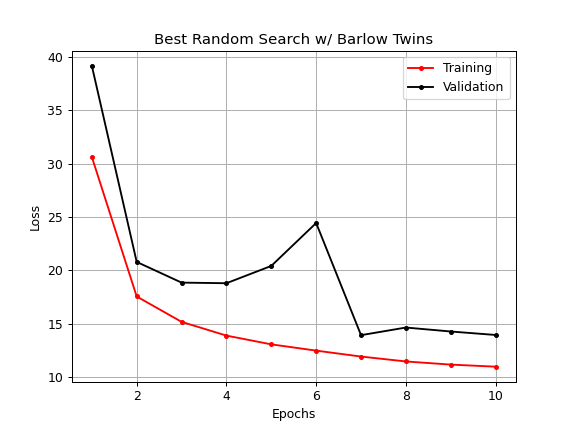

In [23]:
%matplotlib notebook
plot_loss(results["rs-with-barlow-encoder-unfrozen"]["training_losses"],
          results["rs-with-barlow-encoder-unfrozen"]["validation_losses"], "Best Random Search w/ Barlow Twins")

In [26]:
predict_model(results["rs-with-barlow-encoder-unfrozen"]["model"], test_dataloader, "cuda:0", "rs_with_barlow_encoder_unfrozen_drive_predicted")

Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.24it/s]


## RS - FROM SCRATCH

In [27]:
# Tune
# 0.01	32	DiceLoss	0.2	CosineAnnealing	16-32-64
args = {
    "learning_rate": 0.01,
    "unet_layers": "64-128-256",
    "epochs": 10,
    "batch_size": 64,
    "scheduler": "CosineAnnealing",
    "loss_function": "DiceLoss",
    "dropout": 0.2
}
freeze_encoder = False

load_encoder_weights = None

model, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,
                                                                                            load_encoder_weights=load_encoder_weights,
                                                                                            freeze_encoder=freeze_encoder,
                                                                                            seed=1217)

results["rs-from-scratch"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "rs-from-scratch.pkl")

run path C:\Users\shawn\Desktop\Development\CS7643\auto_results\test-drive\--learning_rate=0.01--unet_layers=64-128-256--epochs=10--batch_size=64--scheduler=CosineAnnealing--loss_function=DiceLoss--dropout=0.2


Training:  56%|██████████████████████████████████████████████████████████▉                                               | 100/180 [00:34<00:13,  5.93it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:49<00:00,  3.66it/s]


Training metrics: {'f1_score': 0.4464920229381985, 'sensitivity': 0.5283244184321827, 'specificity': 0.8476088524692589, 'accuracy': 0.8075793796115451, 'auc_roc': 0.7562179487612513, 'mean_iou': 0.2935581156983972, 'ssim': 0.04286222340435618, 'loss': 35.556512663099504}



Epochs:  10%|███████████                                                                                                    | 1/10 [01:10<10:31, 70.20s/it]

Validation metrics: {'f1_score': 0.3450493350935479, 'sensitivity': 0.41195220008182026, 'specificity': 0.8752950648466746, 'accuracy': 0.8175930786132812, 'auc_roc': 0.7967300693194072, 'mean_iou': 0.21393347724806516, 'ssim': 0.036556750481831844, 'loss': 42.04393803914388}
Epoch: 0
Train Loss : 35.5565
Validation Loss : 42.0439
training loss per epoch: [35.556512663099504]
validation loss per epoch: [42.04393803914388]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:30<00:13,  5.79it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:44<00:00,  4.03it/s]


Training metrics: {'f1_score': 0.65678192211522, 'sensitivity': 0.6485686590274174, 'specificity': 0.953739090429412, 'accuracy': 0.9155571937561036, 'auc_roc': 0.8916076285971536, 'mean_iou': 0.48966267158587773, 'ssim': 0.050560271377778715, 'loss': 22.02849008772108}



Epochs:  20%|██████████████████████▏                                                                                        | 2/10 [02:14<08:53, 66.73s/it]

Validation metrics: {'f1_score': 0.5340358305970828, 'sensitivity': 0.4136910644173622, 'specificity': 0.991674788792928, 'accuracy': 0.9188129552205404, 'auc_roc': 0.8896481887499491, 'mean_iou': 0.37986202297111354, 'ssim': 0.002983272007938164, 'loss': 29.8133447265625}
Epoch: 1
Train Loss : 22.0285
Validation Loss : 29.8133
training loss per epoch: [35.556512663099504, 22.02849008772108]
validation loss per epoch: [42.04393803914388, 29.8133447265625]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:32<00:14,  5.44it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:47<00:00,  3.80it/s]


Training metrics: {'f1_score': 0.7162801083591249, 'sensitivity': 0.7159269250101513, 'specificity': 0.959916815161705, 'accuracy': 0.9293717808193631, 'auc_roc': 0.9311956753333409, 'mean_iou': 0.5583806410431862, 'ssim': 0.020756304923755426, 'loss': 18.1915250354343}



Epochs:  30%|█████████████████████████████████▎                                                                             | 3/10 [03:22<07:50, 67.24s/it]

Validation metrics: {'f1_score': 0.7083344441652298, 'sensitivity': 0.7092654496431351, 'specificity': 0.9667669908205668, 'accuracy': 0.9330291493733724, 'auc_roc': 0.9403577280044556, 'mean_iou': 0.5569754173358281, 'ssim': 0.003478674761330088, 'loss': 18.692284240722657}
Epoch: 2
Train Loss : 18.1915
Validation Loss : 18.6923
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:31<00:13,  5.89it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:45<00:00,  3.96it/s]


Training metrics: {'f1_score': 0.7522055049737294, 'sensitivity': 0.7512649406989416, 'specificity': 0.9652028001017041, 'accuracy': 0.9383797963460286, 'auc_roc': 0.9395296470986472, 'mean_iou': 0.6029966910680135, 'ssim': 0.005694440155962689, 'loss': 15.88864091237386}



Epochs:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [04:27<06:39, 66.59s/it]

Validation metrics: {'f1_score': 0.6727248779932657, 'sensitivity': 0.5843253848950068, 'specificity': 0.9860443544387817, 'accuracy': 0.9349080530802408, 'auc_roc': 0.9101786494255066, 'mean_iou': 0.5179447119434675, 'ssim': 0.0016315157474794735, 'loss': 20.98579620361328}
Epoch: 3
Train Loss : 15.8886
Validation Loss : 20.9858
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343, 15.88864091237386]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657, 20.98579620361328]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:31<00:13,  5.88it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:45<00:00,  3.96it/s]


Training metrics: {'f1_score': 0.7723519772291183, 'sensitivity': 0.7713090240955353, 'specificity': 0.9679766684770584, 'accuracy': 0.9433262136247423, 'auc_roc': 0.9354577922158771, 'mean_iou': 0.6292083402474721, 'ssim': 0.0047025585094363324, 'loss': 14.597956106397842}



Epochs:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [05:33<05:30, 66.19s/it]

Validation metrics: {'f1_score': 0.6629192736744881, 'sensitivity': 0.5691140979031721, 'specificity': 0.9876713967323303, 'accuracy': 0.9342634709676106, 'auc_roc': 0.8726152443885803, 'mean_iou': 0.5102143191297849, 'ssim': 0.0017992075659518983, 'loss': 21.60568801879883}
Epoch: 4
Train Loss : 14.5980
Validation Loss : 21.6057
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343, 15.88864091237386, 14.597956106397842]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657, 20.98579620361328, 21.60568801879883]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:32<00:13,  6.04it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:45<00:00,  3.94it/s]


Training metrics: {'f1_score': 0.7850430634286668, 'sensitivity': 0.7834756947225995, 'specificity': 0.9699200587140189, 'accuracy': 0.9465359952714708, 'auc_roc': 0.9350169701708688, 'mean_iou': 0.6462212562561035, 'ssim': 0.005586687105500864, 'loss': 13.784242269727919}



Epochs:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [06:38<04:23, 65.94s/it]

Validation metrics: {'f1_score': 0.7443907817204793, 'sensitivity': 0.7374201097091039, 'specificity': 0.9725421182314555, 'accuracy': 0.9414121882120768, 'auc_roc': 0.9153613607088725, 'mean_iou': 0.6012916274865469, 'ssim': 0.002506602448799337, 'loss': 16.376749674479168}
Epoch: 5
Train Loss : 13.7842
Validation Loss : 16.3767
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343, 15.88864091237386, 14.597956106397842, 13.784242269727919]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657, 20.98579620361328, 21.60568801879883, 16.376749674479168]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:31<00:14,  5.63it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:45<00:00,  3.98it/s]


Training metrics: {'f1_score': 0.7951603972249561, 'sensitivity': 0.7925270944833755, 'specificity': 0.971553251809544, 'accuracy': 0.9491177717844645, 'auc_roc': 0.9369741029209561, 'mean_iou': 0.6600509491231706, 'ssim': 0.006170224864035845, 'loss': 13.134840499030219}



Epochs:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [07:43<03:16, 65.57s/it]

Validation metrics: {'f1_score': 0.749163902203242, 'sensitivity': 0.6812594918409983, 'specificity': 0.9854665533701579, 'accuracy': 0.9457228851318359, 'auc_roc': 0.9077863597869873, 'mean_iou': 0.6059417496124904, 'ssim': 0.0024636986107119205, 'loss': 16.081416829427084}
Epoch: 6
Train Loss : 13.1348
Validation Loss : 16.0814
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343, 15.88864091237386, 14.597956106397842, 13.784242269727919, 13.134840499030219]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657, 20.98579620361328, 21.60568801879883, 16.376749674479168, 16.081416829427084]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:31<00:13,  6.02it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:45<00:00,  3.98it/s]


Training metrics: {'f1_score': 0.802011752459738, 'sensitivity': 0.7989500757720736, 'specificity': 0.9726547761095895, 'accuracy': 0.9508561611175537, 'auc_roc': 0.93848754035102, 'mean_iou': 0.6695359259843826, 'ssim': 0.006131557364844614, 'loss': 12.695685195922852}



Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [08:49<02:11, 65.56s/it]

Validation metrics: {'f1_score': 0.7595277698834737, 'sensitivity': 0.7016439155737559, 'specificity': 0.9837157980600992, 'accuracy': 0.9473612848917643, 'auc_roc': 0.9157650367418925, 'mean_iou': 0.6185970622301101, 'ssim': 0.0026837115141097457, 'loss': 15.415170237223307}
Epoch: 7
Train Loss : 12.6957
Validation Loss : 15.4152
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343, 15.88864091237386, 14.597956106397842, 13.784242269727919, 13.134840499030219, 12.695685195922852]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657, 20.98579620361328, 21.60568801879883, 16.376749674479168, 16.081416829427084, 15.415170237223307]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:31<00:13,  6.02it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:45<00:00,  3.98it/s]


Training metrics: {'f1_score': 0.8065316673782137, 'sensitivity': 0.8030370258622699, 'specificity': 0.973460794488589, 'accuracy': 0.9520448631710476, 'auc_roc': 0.939194091823366, 'mean_iou': 0.6758392357163959, 'ssim': 0.006708892724580235, 'loss': 12.40607664320204}



Epochs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [09:54<01:05, 65.48s/it]

Validation metrics: {'f1_score': 0.7797838449478149, 'sensitivity': 0.771942689816157, 'specificity': 0.9754198042551676, 'accuracy': 0.9483611297607422, 'auc_roc': 0.9305711404482524, 'mean_iou': 0.6442511663834254, 'ssim': 0.002860435798841839, 'loss': 14.114759012858073}
Epoch: 8
Train Loss : 12.4061
Validation Loss : 14.1148
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343, 15.88864091237386, 14.597956106397842, 13.784242269727919, 13.134840499030219, 12.695685195922852, 12.40607664320204]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657, 20.98579620361328, 21.60568801879883, 16.376749674479168, 16.081416829427084, 15.415170237223307, 14.114759012858073]



Training:  56%|███████████████████████████████████████████████████████████▍                                              | 101/180 [00:31<00:13,  5.74it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:45<00:00,  3.96it/s]


Training metrics: {'f1_score': 0.8091977404223548, 'sensitivity': 0.8054494119352764, 'specificity': 0.9738165878587299, 'accuracy': 0.9526955127716065, 'auc_roc': 0.9393662277195188, 'mean_iou': 0.6796154800388549, 'ssim': 0.006967664153004686, 'loss': 12.235737588670519}



Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:59<00:00, 65.99s/it]

Validation metrics: {'f1_score': 0.781243325471878, 'sensitivity': 0.7664850719769796, 'specificity': 0.9768493398030599, 'accuracy': 0.9491033554077148, 'auc_roc': 0.9309553043047587, 'mean_iou': 0.6465360033512115, 'ssim': 0.002937860651873052, 'loss': 14.02353729248047}
Epoch: 9
Train Loss : 12.2357
Validation Loss : 14.0235
training loss per epoch: [35.556512663099504, 22.02849008772108, 18.1915250354343, 15.88864091237386, 14.597956106397842, 13.784242269727919, 13.134840499030219, 12.695685195922852, 12.40607664320204, 12.235737588670519]
validation loss per epoch: [42.04393803914388, 29.8133447265625, 18.692284240722657, 20.98579620361328, 21.60568801879883, 16.376749674479168, 16.081416829427084, 15.415170237223307, 14.114759012858073, 14.02353729248047]


<IPython.core.display.Javascript object>


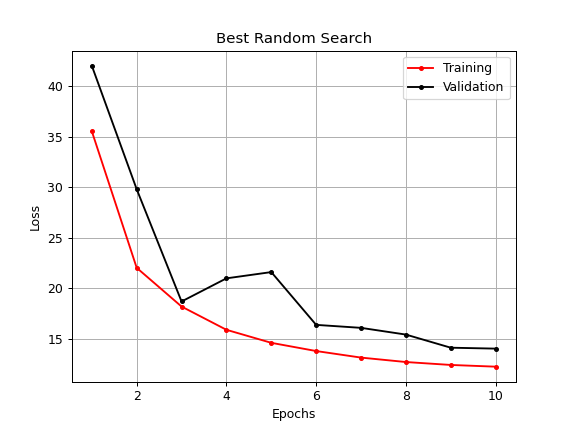

In [30]:
%matplotlib notebook
plot_loss(results["rs-from-scratch"]["training_losses"],
          results["rs-from-scratch"]["validation_losses"], "Best Random Search")

In [29]:
predict_model(results["rs-from-scratch"]["model"], test_dataloader, "cuda:0", "rs_from_scratch")

Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.30it/s]


In [20]:
#import pickle
#results = {}
#with open("./rs-with-barlow-encoder-unfrozen.pkl", "rb") as f:
#    results["rs-with-barlow-encoder-unfrozen"] = pickle.load(f)

<IPython.core.display.Javascript object>


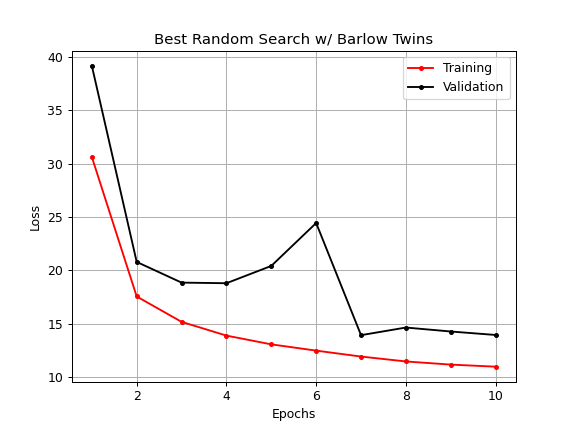

In [23]:
%matplotlib notebook
plot_loss(results["rs-with-barlow-encoder-unfrozen"]["training_losses"],
          results["rs-with-barlow-encoder-unfrozen"]["validation_losses"], "Best Random Search w/ Barlow Twins")

In [26]:
predict_model(results["rs-with-barlow-encoder-unfrozen"]["model"], test_dataloader, "cuda:0", "rs_with_barlow_encoder_unfrozen_drive_predicted")

Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.24it/s]


## TUNE - BARLOW - UNFROZEN

In [19]:
# Tune
# Tune
# 0.01	32	DiceLoss	0.2	CosineAnnealing	16-32-64
args = {
    "learning_rate": 0.01,
    "unet_layers": "16-32-64",
    "epochs": 10,
    "batch_size": 32,
    "scheduler": "CosineAnnealing",
    "loss_function": "DiceLoss",
    "dropout": 0.2
}

freeze_encoder = False

load_encoder_weights = "../checkpoint/Barlow/16-32-64/29unetEncoder.pth"

model, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,
                                                                                            load_encoder_weights=load_encoder_weights,
                                                                                            freeze_encoder=freeze_encoder,
                                                                                            seed=712)

results["tune-barlow-unfrozen"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "tune-barlow-unfrozen.pkl")

run path C:\Users\shawn\Desktop\Development\CS7643\auto_results\test-drive\--learning_rate=0.01--unet_layers=16-32-64--epochs=10--batch_size=32--scheduler=CosineAnnealing--loss_function=DiceLoss--dropout=0.2



Epochs:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:28:29, 14.79s/it]

Training:   1%|▌                                                                                                           | 2/360 [00:14<36:57,  6.20s/it]

Training:   1%|█▌                                                                                                          | 5/360 [00:15<10:35,  1.79s/it]

Training:   2%|██▍                                                                                                         | 8/360 [00:15<05:18,  1.10it/s]

Training:   3%|███▎                                      

Training:  40%|██████████████████████████████████████████                                                                | 143/360 [00:20<00:08, 25.71it/s]

Training:  41%|██████████████████████████████████████████▉                                                               | 146/360 [00:20<00:08, 25.64it/s]

Training:  41%|███████████████████████████████████████████▊                                                              | 149/360 [00:20<00:08, 25.77it/s]

Training:  42%|████████████████████████████████████████████▊                                                             | 152/360 [00:21<00:08, 25.07it/s]

Training:  43%|█████████████████████████████████████████████▋                                                            | 155/360 [00:21<00:08, 23.23it/s]

Training:  44%|██████████████████████████████████████████████▌                                                           | 158/360 [00:21<00:09, 22.19it/s]

Training:  45%|███████████████████████████████████████████

Training:  87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 313/360 [00:26<00:01, 29.36it/s]

Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 316/360 [00:26<00:01, 28.69it/s]

Training:  89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 319/360 [00:26<00:01, 27.91it/s]

Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊           | 322/360 [00:27<00:01, 28.20it/s]

Training:  91%|███████████████████████████████████████████████████████████████████████████████████████████████▉          | 326/360 [00:27<00:01, 28.85it/s]

Training:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▏        | 330/360 [00:27<00:01, 29.56it/s]

Training:  92%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.5168445281684398, 'sensitivity': 0.6970337213741409, 'specificity': 0.7672454171917504, 'accuracy': 0.758119191063775, 'auc_roc': 0.7800947656234105, 'mean_iou': 0.36524502988904717, 'ssim': 0.01675037420484134, 'loss': 15.494014067120021}




Validation:   0%|                                                                                                                  | 0/150 [00:00<?, ?it/s]

Validation:   1%|▋                                                                                                         | 1/150 [00:14<35:53, 14.45s/it]

Validation:   3%|██▊                                                                                                       | 4/150 [00:14<06:44,  2.77s/it]

Validation:   5%|████▉                                                                                                     | 7/150 [00:14<03:06,  1.30s/it]

Validation:   9%|█████████                                                                                                | 13/150 [00:14<01:12,  1.90it/s]

Validation:  13%|█████████████▎                                                                                           | 19/150 [00:14<00:38,  3.44it/s]

Validation:  17%|█████████████████▌                     

Validation metrics: {'f1_score': 0.6098313510914644, 'sensitivity': 0.5271565425706406, 'specificity': 0.9833691155910492, 'accuracy': 0.9240920766194661, 'auc_roc': 0.8375676741202672, 'mean_iou': 0.45397068199391166, 'ssim': 0.001314281786956902, 'loss': 12.501847025553385}
Epoch: 0
Train Loss : 15.4940
Validation Loss : 12.5018
training loss per epoch: [15.494014067120021]
validation loss per epoch: [12.501847025553385]




Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:27:05, 14.56s/it]

Training:   1%|▌                                                                                                           | 2/360 [00:14<36:09,  6.06s/it]

Training:   1%|▉                                                                                                           | 3/360 [00:14<19:53,  3.34s/it]

Training:   2%|█▊                                                                                                          | 6/360 [00:14<06:49,  1.16s/it]

Training:   2%|██▋                                                                                                         | 9/360 [00:14<03:34,  1.64it/s]

Training:   3%|███▌                                     

Training:  43%|█████████████████████████████████████████████▎                                                            | 154/360 [00:20<00:08, 25.62it/s]

Training:  44%|██████████████████████████████████████████████▏                                                           | 157/360 [00:20<00:07, 25.62it/s]

Training:  44%|███████████████████████████████████████████████                                                           | 160/360 [00:20<00:07, 25.71it/s]

Training:  45%|███████████████████████████████████████████████▉                                                          | 163/360 [00:20<00:07, 25.94it/s]

Training:  46%|████████████████████████████████████████████████▉                                                         | 166/360 [00:20<00:07, 26.35it/s]

Training:  47%|█████████████████████████████████████████████████▊                                                        | 169/360 [00:20<00:07, 26.20it/s]

Training:  48%|███████████████████████████████████████████

Training:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 304/360 [00:25<00:02, 24.81it/s]

Training:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 307/360 [00:26<00:02, 23.37it/s]

Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 310/360 [00:26<00:02, 23.06it/s]

Training:  87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 313/360 [00:26<00:01, 23.83it/s]

Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 316/360 [00:26<00:01, 22.71it/s]

Training:  89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 319/360 [00:26<00:01, 22.96it/s]

Training:  89%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.6992692728837331, 'sensitivity': 0.696232737435235, 'specificity': 0.9584941229886479, 'accuracy': 0.9254985968271892, 'auc_roc': 0.8976774962411986, 'mean_iou': 0.5382316596806049, 'ssim': 0.006687293798636852, 'loss': 9.63990388446384}




Validation:   0%|                                                                                                                  | 0/150 [00:00<?, ?it/s]

Validation:   1%|▋                                                                                                         | 1/150 [00:14<35:54, 14.46s/it]

Validation:   2%|██                                                                                                        | 3/150 [00:14<09:18,  3.80s/it]

Validation:   5%|█████▋                                                                                                    | 8/150 [00:14<02:30,  1.06s/it]

Validation:   9%|█████████                                                                                                | 13/150 [00:14<01:13,  1.88it/s]

Validation:  13%|█████████████▎                                                                                           | 19/150 [00:14<00:38,  3.41it/s]

Validation:  16%|████████████████▊                      

Validation metrics: {'f1_score': 0.6979375365376472, 'sensitivity': 0.7029347792267799, 'specificity': 0.96513547539711, 'accuracy': 0.9297378158569336, 'auc_roc': 0.9108202048142751, 'mean_iou': 0.5432673292855422, 'ssim': 0.0021835657552583144, 'loss': 9.681621589660644}
Epoch: 1
Train Loss : 9.6399
Validation Loss : 9.6816
training loss per epoch: [15.494014067120021, 9.63990388446384]
validation loss per epoch: [12.501847025553385, 9.681621589660644]




Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:25:17, 14.26s/it]

Training:   1%|▉                                                                                                           | 3/360 [00:14<22:25,  3.77s/it]

Training:   1%|█▌                                                                                                          | 5/360 [00:14<11:00,  1.86s/it]

Training:   2%|██▍                                                                                                         | 8/360 [00:14<05:17,  1.11it/s]

Training:   3%|███▎                                                                                                       | 11/360 [00:14<03:05,  1.88it/s]

Training:   4%|████▏                                    

Training:  44%|██████████████████████████████████████████████▌                                                           | 158/360 [00:20<00:06, 29.84it/s]

Training:  45%|███████████████████████████████████████████████▋                                                          | 162/360 [00:20<00:06, 29.76it/s]

Training:  46%|████████████████████████████████████████████████▉                                                         | 166/360 [00:20<00:06, 29.60it/s]

Training:  47%|██████████████████████████████████████████████████                                                        | 170/360 [00:20<00:06, 29.89it/s]

Training:  48%|██████████████████████████████████████████████████▉                                                       | 173/360 [00:20<00:06, 28.16it/s]

Training:  49%|███████████████████████████████████████████████████▊                                                      | 176/360 [00:20<00:06, 27.78it/s]

Training:  50%|███████████████████████████████████████████

Training:  87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 312/360 [00:25<00:01, 28.72it/s]

Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 315/360 [00:26<00:01, 28.98it/s]

Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋            | 318/360 [00:26<00:01, 28.55it/s]

Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊           | 322/360 [00:26<00:01, 29.09it/s]

Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 325/360 [00:26<00:01, 28.56it/s]

Training:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▌         | 328/360 [00:26<00:01, 28.89it/s]

Training:  92%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.728752900328901, 'sensitivity': 0.7234408585561647, 'specificity': 0.963261042535305, 'accuracy': 0.9330706225501166, 'auc_roc': 0.9181060388684272, 'mean_iou': 0.5736028840144475, 'ssim': 0.005553206776837922, 'loss': 8.694647497600979}




Validation:   0%|                                                                                                                  | 0/150 [00:00<?, ?it/s]

Validation:   1%|▋                                                                                                         | 1/150 [00:14<35:58, 14.48s/it]

Validation:   2%|██                                                                                                        | 3/150 [00:14<09:17,  3.79s/it]

Validation:   5%|█████▋                                                                                                    | 8/150 [00:14<02:30,  1.06s/it]

Validation:   9%|█████████                                                                                                | 13/150 [00:14<01:12,  1.89it/s]

Validation:  12%|████████████▌                                                                                            | 18/150 [00:14<00:41,  3.17it/s]

Validation:  15%|████████████████                       

Validation metrics: {'f1_score': 0.6991153493523597, 'sensitivity': 0.7170688977837563, 'specificity': 0.9617891899744669, 'accuracy': 0.9286369959513346, 'auc_roc': 0.9189093848069508, 'mean_iou': 0.5442802835504214, 'ssim': 0.0024152576964115726, 'loss': 9.636995340983074}
Epoch: 2
Train Loss : 8.6946
Validation Loss : 9.6370
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074]




Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:27:30, 14.63s/it]

Training:   1%|▌                                                                                                           | 2/360 [00:14<36:17,  6.08s/it]

Training:   1%|█▏                                                                                                          | 4/360 [00:14<13:44,  2.32s/it]

Training:   2%|██                                                                                                          | 7/360 [00:15<05:57,  1.01s/it]

Training:   3%|██▉                                                                                                        | 10/360 [00:15<03:20,  1.75it/s]

Training:   4%|███▊                                     

Training:  42%|████████████████████████████████████████████▏                                                             | 150/360 [00:20<00:08, 25.00it/s]

Training:  42%|█████████████████████████████████████████████                                                             | 153/360 [00:20<00:07, 26.13it/s]

Training:  44%|██████████████████████████████████████████████▏                                                           | 157/360 [00:20<00:07, 27.74it/s]

Training:  44%|███████████████████████████████████████████████                                                           | 160/360 [00:20<00:07, 27.45it/s]

Training:  45%|███████████████████████████████████████████████▉                                                          | 163/360 [00:20<00:07, 26.66it/s]

Training:  46%|████████████████████████████████████████████████▉                                                         | 166/360 [00:20<00:07, 26.52it/s]

Training:  47%|███████████████████████████████████████████

Training:  85%|██████████████████████████████████████████████████████████████████████████████████████████                | 306/360 [00:26<00:01, 29.44it/s]

Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 310/360 [00:26<00:01, 29.66it/s]

Training:  87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 313/360 [00:26<00:01, 29.67it/s]

Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 316/360 [00:26<00:01, 29.27it/s]

Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 320/360 [00:26<00:01, 29.90it/s]

Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████           | 323/360 [00:26<00:01, 29.48it/s]

Training:  91%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.7443559467792511, 'sensitivity': 0.7392668025361167, 'specificity': 0.9652821340494686, 'accuracy': 0.936853747897678, 'auc_roc': 0.9253152678410212, 'mean_iou': 0.5930758479568693, 'ssim': 0.005555299864176454, 'loss': 8.192566188176473}




Validation:   0%|                                                                                                                  | 0/150 [00:00<?, ?it/s]

Validation:   1%|▋                                                                                                         | 1/150 [00:14<36:19, 14.63s/it]

Validation:   3%|██▊                                                                                                       | 4/150 [00:14<06:49,  2.80s/it]

Validation:   5%|█████▋                                                                                                    | 8/150 [00:14<02:38,  1.12s/it]

Validation:   9%|█████████                                                                                                | 13/150 [00:14<01:15,  1.82it/s]

Validation:  13%|█████████████▎                                                                                           | 19/150 [00:15<00:39,  3.34it/s]

Validation:  17%|█████████████████▌                     

Validation metrics: {'f1_score': 0.6178505191858857, 'sensitivity': 0.532100519653953, 'specificity': 0.985639324982961, 'accuracy': 0.9265653991699219, 'auc_roc': 0.8584441566467285, 'mean_iou': 0.4660417025837038, 'ssim': 0.0012945387591995919, 'loss': 12.23494977315267}
Epoch: 3
Train Loss : 8.1926
Validation Loss : 12.2349
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979, 8.192566188176473]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074, 12.23494977315267]




Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:26:28, 14.45s/it]

Training:   1%|▌                                                                                                           | 2/360 [00:14<35:55,  6.02s/it]

Training:   1%|▉                                                                                                           | 3/360 [00:14<19:45,  3.32s/it]

Training:   2%|█▊                                                                                                          | 6/360 [00:14<06:47,  1.15s/it]

Training:   2%|██▋                                                                                                         | 9/360 [00:14<03:34,  1.63it/s]

Training:   3%|███▌                                     

Training:  41%|███████████████████████████████████████████▊                                                              | 149/360 [00:20<00:07, 29.54it/s]

Training:  42%|████████████████████████████████████████████▊                                                             | 152/360 [00:20<00:07, 29.02it/s]

Training:  43%|█████████████████████████████████████████████▉                                                            | 156/360 [00:20<00:06, 29.47it/s]

Training:  44%|██████████████████████████████████████████████▊                                                           | 159/360 [00:20<00:06, 29.37it/s]

Training:  45%|███████████████████████████████████████████████▉                                                          | 163/360 [00:20<00:06, 29.11it/s]

Training:  46%|████████████████████████████████████████████████▉                                                         | 166/360 [00:20<00:06, 28.33it/s]

Training:  47%|███████████████████████████████████████████

Training:  84%|████████████████████████████████████████████████████████████████████████████████████████▉                 | 302/360 [00:26<00:02, 23.36it/s]

Training:  85%|█████████████████████████████████████████████████████████████████████████████████████████▊                | 305/360 [00:26<00:02, 23.40it/s]

Training:  86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 308/360 [00:26<00:02, 23.68it/s]

Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 311/360 [00:26<00:02, 23.43it/s]

Training:  87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 314/360 [00:26<00:02, 22.89it/s]

Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 317/360 [00:26<00:01, 22.83it/s]

Training:  89%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.7530714179078738, 'sensitivity': 0.7475256737735536, 'specificity': 0.9666259245740043, 'accuracy': 0.939056290520562, 'auc_roc': 0.9282462494240866, 'mean_iou': 0.6042078249984317, 'ssim': 0.00543465055913354, 'loss': 7.9124378151363794}




Validation:   0%|                                                                                                                  | 0/150 [00:00<?, ?it/s]

Validation:   1%|▋                                                                                                         | 1/150 [00:14<36:15, 14.60s/it]

Validation:   2%|██                                                                                                        | 3/150 [00:14<09:22,  3.83s/it]

Validation:   4%|████▏                                                                                                     | 6/150 [00:14<03:36,  1.50s/it]

Validation:   7%|███████                                                                                                  | 10/150 [00:14<01:39,  1.41it/s]

Validation:  11%|███████████▏                                                                                             | 16/150 [00:15<00:45,  2.95it/s]

Validation:  15%|███████████████▍                       

Validation metrics: {'f1_score': 0.7202989878257116, 'sensitivity': 0.7448285543918609, 'specificity': 0.9612012108167013, 'accuracy': 0.9319125111897787, 'auc_roc': 0.9280551719665527, 'mean_iou': 0.5677302800615629, 'ssim': 0.0025309130576594424, 'loss': 8.959991086324056}
Epoch: 4
Train Loss : 7.9124
Validation Loss : 8.9600
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979, 8.192566188176473, 7.9124378151363794]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074, 12.23494977315267, 8.959991086324056]




Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:27:35, 14.64s/it]

Training:   1%|▌                                                                                                           | 2/360 [00:14<36:20,  6.09s/it]

Training:   1%|▉                                                                                                           | 3/360 [00:14<19:58,  3.36s/it]

Training:   2%|█▊                                                                                                          | 6/360 [00:14<06:52,  1.16s/it]

Training:   2%|██▋                                                                                                         | 9/360 [00:15<03:36,  1.62it/s]

Training:   3%|███▌                                     

Training:  40%|██████████████████████████████████████████▍                                                               | 144/360 [00:20<00:08, 25.10it/s]

Training:  41%|███████████████████████████████████████████▎                                                              | 147/360 [00:20<00:08, 25.74it/s]

Training:  42%|████████████████████████████████████████████▍                                                             | 151/360 [00:20<00:07, 27.28it/s]

Training:  43%|█████████████████████████████████████████████▋                                                            | 155/360 [00:20<00:07, 28.20it/s]

Training:  44%|██████████████████████████████████████████████▌                                                           | 158/360 [00:20<00:07, 27.96it/s]

Training:  45%|███████████████████████████████████████████████▍                                                          | 161/360 [00:21<00:07, 27.54it/s]

Training:  46%|███████████████████████████████████████████

Training:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                  | 296/360 [00:26<00:02, 25.70it/s]

Training:  83%|████████████████████████████████████████████████████████████████████████████████████████                  | 299/360 [00:26<00:02, 25.91it/s]

Training:  84%|████████████████████████████████████████████████████████████████████████████████████████▉                 | 302/360 [00:26<00:02, 25.98it/s]

Training:  85%|█████████████████████████████████████████████████████████████████████████████████████████▊                | 305/360 [00:26<00:02, 26.04it/s]

Training:  86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 308/360 [00:26<00:02, 25.94it/s]

Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 311/360 [00:26<00:01, 25.91it/s]

Training:  87%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.7589899284972085, 'sensitivity': 0.7537585172388289, 'specificity': 0.9674083716339535, 'accuracy': 0.9405274391174316, 'auc_roc': 0.9301207295722431, 'mean_iou': 0.6118447808755769, 'ssim': 0.00546842739244716, 'loss': 7.721608209609985}




Validation:   0%|                                                                                                                  | 0/150 [00:00<?, ?it/s]

Validation:   1%|▋                                                                                                         | 1/150 [00:14<35:18, 14.22s/it]

Validation:   4%|████▏                                                                                                     | 6/150 [00:14<04:14,  1.77s/it]

Validation:   8%|████████▍                                                                                                | 12/150 [00:14<01:39,  1.39it/s]

Validation:  12%|████████████▌                                                                                            | 18/150 [00:14<00:52,  2.53it/s]

Validation:  16%|████████████████▊                                                                                        | 24/150 [00:14<00:31,  4.06it/s]

Validation:  20%|█████████████████████                  

Validation metrics: {'f1_score': 0.7458198821544647, 'sensitivity': 0.763447340130806, 'specificity': 0.9671022593975067, 'accuracy': 0.9392151514689128, 'auc_roc': 0.9374816020329794, 'mean_iou': 0.5998019433021545, 'ssim': 0.0020217252450917536, 'loss': 8.139529012044271}
Epoch: 5
Train Loss : 7.7216
Validation Loss : 8.1395
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979, 8.192566188176473, 7.9124378151363794, 7.721608209609985]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074, 12.23494977315267, 8.959991086324056, 8.139529012044271]




Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:28:14, 14.75s/it]

Training:   1%|▌                                                                                                           | 2/360 [00:14<36:37,  6.14s/it]

Training:   1%|█▏                                                                                                          | 4/360 [00:14<13:49,  2.33s/it]

Training:   2%|██                                                                                                          | 7/360 [00:15<05:59,  1.02s/it]

Training:   3%|██▉                                                                                                        | 10/360 [00:15<03:22,  1.73it/s]

Training:   4%|███▊                                     

Training:  41%|███████████████████████████████████████████▊                                                              | 149/360 [00:20<00:08, 23.85it/s]

Training:  42%|████████████████████████████████████████████▊                                                             | 152/360 [00:20<00:09, 22.80it/s]

Training:  43%|█████████████████████████████████████████████▋                                                            | 155/360 [00:20<00:08, 22.93it/s]

Training:  44%|██████████████████████████████████████████████▌                                                           | 158/360 [00:21<00:08, 23.53it/s]

Training:  45%|███████████████████████████████████████████████▍                                                          | 161/360 [00:21<00:08, 23.14it/s]

Training:  46%|████████████████████████████████████████████████▎                                                         | 164/360 [00:21<00:08, 24.14it/s]

Training:  46%|███████████████████████████████████████████

Training:  83%|████████████████████████████████████████████████████████████████████████████████████████                  | 299/360 [00:26<00:02, 26.56it/s]

Training:  84%|████████████████████████████████████████████████████████████████████████████████████████▉                 | 302/360 [00:26<00:02, 25.89it/s]

Training:  85%|█████████████████████████████████████████████████████████████████████████████████████████▊                | 305/360 [00:26<00:02, 25.81it/s]

Training:  86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 308/360 [00:26<00:02, 25.81it/s]

Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 311/360 [00:26<00:01, 26.04it/s]

Training:  87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 314/360 [00:27<00:01, 25.91it/s]

Training:  88%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.7638635352253914, 'sensitivity': 0.7586946311924193, 'specificity': 0.9680026077561908, 'accuracy': 0.9416586346096463, 'auc_roc': 0.9319951484600703, 'mean_iou': 0.6181730237272051, 'ssim': 0.00574133980488922, 'loss': 7.56523134443495}




Validation:   0%|                                                                                                                  | 0/150 [00:00<?, ?it/s]

Validation:   1%|▋                                                                                                         | 1/150 [00:14<36:06, 14.54s/it]

Validation:   2%|██                                                                                                        | 3/150 [00:14<09:20,  3.81s/it]

Validation:   5%|█████▋                                                                                                    | 8/150 [00:14<02:30,  1.06s/it]

Validation:   9%|█████████                                                                                                | 13/150 [00:14<01:12,  1.88it/s]

Validation:  12%|████████████▌                                                                                            | 18/150 [00:14<00:41,  3.15it/s]

Validation:  15%|████████████████                       

Validation metrics: {'f1_score': 0.7449389882882436, 'sensitivity': 0.7121939580639204, 'specificity': 0.9780502259731293, 'accuracy': 0.9425129572550456, 'auc_roc': 0.9320615720748902, 'mean_iou': 0.5993505246440569, 'ssim': 0.0018441635661292821, 'loss': 8.169105682373047}
Epoch: 6
Train Loss : 7.5652
Validation Loss : 8.1691
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979, 8.192566188176473, 7.9124378151363794, 7.721608209609985, 7.56523134443495]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074, 12.23494977315267, 8.959991086324056, 8.139529012044271, 8.169105682373047]




Training:   0%|                                                                                                                    | 0/360 [00:00<?, ?it/s]

Training:   0%|▎                                                                                                         | 1/360 [00:14<1:24:57, 14.20s/it]

Training:   1%|▌                                                                                                           | 2/360 [00:14<35:14,  5.91s/it]

Training:   1%|█▏                                                                                                          | 4/360 [00:14<13:20,  2.25s/it]

Training:   2%|██                                                                                                          | 7/360 [00:14<05:46,  1.02it/s]

Training:   3%|██▉                                                                                                        | 10/360 [00:14<03:15,  1.79it/s]

Training:   4%|███▊                                     

Training:  41%|██████████████████████████████████████████▉                                                               | 146/360 [00:19<00:07, 27.80it/s]

Training:  41%|███████████████████████████████████████████▊                                                              | 149/360 [00:19<00:07, 28.13it/s]

Training:  42%|████████████████████████████████████████████▊                                                             | 152/360 [00:20<00:07, 28.17it/s]

Training:  43%|█████████████████████████████████████████████▋                                                            | 155/360 [00:20<00:07, 28.52it/s]

Training:  44%|██████████████████████████████████████████████▊                                                           | 159/360 [00:20<00:06, 29.17it/s]

Training:  45%|███████████████████████████████████████████████▉                                                          | 163/360 [00:20<00:06, 29.31it/s]

Training:  46%|███████████████████████████████████████████

Training:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 304/360 [00:25<00:02, 27.32it/s]

Training:  86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 308/360 [00:25<00:01, 27.92it/s]

Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 311/360 [00:25<00:01, 27.30it/s]

Training:  87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 314/360 [00:26<00:01, 26.06it/s]

Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 317/360 [00:26<00:01, 25.99it/s]

Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▌           | 321/360 [00:26<00:01, 27.67it/s]

Training:  90%|███████████████████████████████████████████

Training metrics: {'f1_score': 0.7674430663386981, 'sensitivity': 0.7623208143644863, 'specificity': 0.9685709507928955, 'accuracy': 0.942600753572252, 'auc_roc': 0.9325671816865603, 'mean_iou': 0.6229146298434999, 'ssim': 0.005870526159156321, 'loss': 7.451634099748399}




Epochs:   0%|                                                                                                                       | 0/10 [34:15<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021E043EF310>
Traceback (most recent call last):
  File "C:\Users\shawn\anaconda3\envs\cs7643-final\lib\site-packages\torch\utils\data\dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "C:\Users\shawn\anaconda3\envs\cs7643-final\lib\site-packages\torch\utils\data\dataloader.py", line 1316, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Validation:   1%|▋                                                                                                         | 1/150 [00:14<36:38, 14.75s/it]

Validation:   2%|██                                                                                         

Validation metrics: {'f1_score': 0.7492071002721786, 'sensitivity': 0.7167143766085307, 'specificity': 0.9779649376869202, 'accuracy': 0.9431626764933269, 'auc_roc': 0.9316730539004008, 'mean_iou': 0.6036536094546318, 'ssim': 0.0020323588037475322, 'loss': 8.03249382019043}
Epoch: 7
Train Loss : 7.4516
Validation Loss : 8.0325
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979, 8.192566188176473, 7.9124378151363794, 7.721608209609985, 7.56523134443495, 7.451634099748399]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074, 12.23494977315267, 8.959991086324056, 8.139529012044271, 8.169105682373047, 8.03249382019043]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:27<00:00, 13.19it/s]


Training metrics: {'f1_score': 0.7703736060195499, 'sensitivity': 0.7650179475545883, 'specificity': 0.9689414294229614, 'accuracy': 0.9433003160688612, 'auc_roc': 0.932473588652081, 'mean_iou': 0.62675029569202, 'ssim': 0.005921057340068122, 'loss': 7.357918887668186}


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:18<00:00,  8.30it/s]

                                                                                                                                                        
Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [06:59<01:33, 46.72s/it]
                                                                                                                                                        
Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [06:59<01:33, 46.72s/it]
                                                                                                                                                        
Epochs:  80%|███████████████████████████████████████████████████████████

Validation metrics: {'f1_score': 0.753865495522817, 'sensitivity': 0.7443763195474943, 'specificity': 0.9733725623289744, 'accuracy': 0.9426431020100912, 'auc_roc': 0.9361193287372589, 'mean_iou': 0.6093142166733742, 'ssim': 0.002098659867964064, 'loss': 7.881899490356445}
Epoch: 8
Train Loss : 7.3579
Validation Loss : 7.8819
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979, 8.192566188176473, 7.9124378151363794, 7.721608209609985, 7.56523134443495, 7.451634099748399, 7.357918887668186]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074, 12.23494977315267, 8.959991086324056, 8.139529012044271, 8.169105682373047, 8.03249382019043, 7.881899490356445]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:27<00:00, 12.91it/s]


Training metrics: {'f1_score': 0.7723876670002937, 'sensitivity': 0.7671939715743065, 'specificity': 0.969138232866923, 'accuracy': 0.9437632454766167, 'auc_roc': 0.9330737877223226, 'mean_iou': 0.629419767525461, 'ssim': 0.005762213919337632, 'loss': 7.292591487036811}


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.79it/s]

                                                                                                                                                        
Epochs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [07:44<00:46, 46.31s/it]
                                                                                                                                                        
Epochs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [07:44<00:46, 46.31s/it]
                                                                                                                                                        
Epochs:  90%|███████████████████████████████████████████████████████████

Validation metrics: {'f1_score': 0.7517506966988245, 'sensitivity': 0.7339247505863508, 'specificity': 0.9753752263387044, 'accuracy': 0.942927360534668, 'auc_roc': 0.9293299051125844, 'mean_iou': 0.6074706489841143, 'ssim': 0.00216700723026103, 'loss': 7.950736948649088}
Epoch: 9
Train Loss : 7.2926
Validation Loss : 7.9507
training loss per epoch: [15.494014067120021, 9.63990388446384, 8.694647497600979, 8.192566188176473, 7.9124378151363794, 7.721608209609985, 7.56523134443495, 7.451634099748399, 7.357918887668186, 7.292591487036811]
validation loss per epoch: [12.501847025553385, 9.681621589660644, 9.636995340983074, 12.23494977315267, 8.959991086324056, 8.139529012044271, 8.169105682373047, 8.03249382019043, 7.881899490356445, 7.950736948649088]


<IPython.core.display.Javascript object>


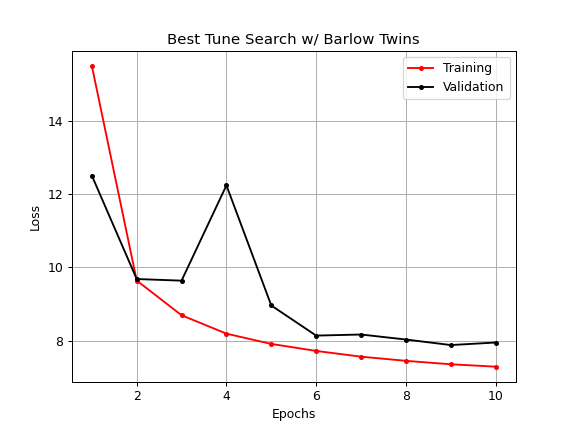

In [22]:
%matplotlib notebook
plot_loss(results["tune-barlow-unfrozen"]["training_losses"],
          results["tune-barlow-unfrozen"]["validation_losses"], "Best Tune Search w/ Barlow Twins")

In [25]:
predict_model(results["tune-barlow-unfrozen"]["model"], test_dataloader, "cuda:0", "tune_barlow_unfrozen_drive_predicted")

Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.82it/s]


## TUNE - FROM SCRATCH

In [26]:
# Tune
# Tune
# 0.01	32	DiceLoss	0.2	CosineAnnealing	16-32-64
args = {
    "learning_rate": 0.01,
    "unet_layers": "16-32-64",
    "epochs": 10,
    "batch_size": 32,
    "scheduler": "CosineAnnealing",
    "loss_function": "DiceLoss",
    "dropout": 0.2
}

freeze_encoder = False

load_encoder_weights = None

model, training_losses, validation_losses, train_metrics, validation_metrics = create_model(args,
                                                                                            load_encoder_weights=load_encoder_weights,
                                                                                            freeze_encoder=freeze_encoder,
                                                                                            seed=1111)

results["tune-from-scratch"] = create_save(args, model, training_losses, validation_losses, train_metrics, validation_metrics, "tune-from-scratch.pkl")

run path C:\Users\shawn\Desktop\Development\CS7643\auto_results\test-drive\--learning_rate=0.01--unet_layers=16-32-64--epochs=10--batch_size=32--scheduler=CosineAnnealing--loss_function=DiceLoss--dropout=0.2


Training:  40%|██████████████████████████████████████████                                                                | 143/360 [00:19<00:08, 25.85it/s]


Training:  83%|███████████████████████████████████████████████████████████████████████████████████████▋                  | 298/360 [00:25<00:02, 26.07it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:28<00:00, 12.55it/s]


Training metrics: {'f1_score': 0.5425906671832005, 'sensitivity': 0.6051171734929085, 'specificity': 0.882016131385333, 'accuracy': 0.8471801704830594, 'auc_roc': 0.8222094360325072, 'mean_iou': 0.3835580325478481, 'ssim': 0.058667964049770184, 'loss': 14.797277328703139}



Epochs:  10%|███████████                                                                                                    | 1/10 [00:46<06:57, 46.43s/it]

Validation metrics: {'f1_score': 0.6699837962786357, 'sensitivity': 0.6136321868995825, 'specificity': 0.9761563082536061, 'accuracy': 0.9297580337524414, 'auc_roc': 0.91983203291893, 'mean_iou': 0.5093763071795304, 'ssim': 0.009937627151715181, 'loss': 10.581582819620769}
Epoch: 0
Train Loss : 14.7973
Validation Loss : 10.5816
training loss per epoch: [14.797277328703139]
validation loss per epoch: [10.581582819620769]



Training:  42%|████████████████████████████████████████████▏                                                             | 150/360 [00:20<00:08, 25.89it/s]


Training:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 307/360 [00:25<00:01, 27.88it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:28<00:00, 12.83it/s]


Training metrics: {'f1_score': 0.7312308349543147, 'sensitivity': 0.7331398285097546, 'specificity': 0.9620365661051539, 'accuracy': 0.9331435362497965, 'auc_roc': 0.9212789785530832, 'mean_iou': 0.5769340470433235, 'ssim': 0.014461002863633136, 'loss': 8.647395843929715}



Epochs:  20%|██████████████████████▏                                                                                        | 2/10 [01:32<06:11, 46.48s/it]

Validation metrics: {'f1_score': 0.7334764748811722, 'sensitivity': 0.784889283378919, 'specificity': 0.9531201759974162, 'accuracy': 0.9319935989379883, 'auc_roc': 0.9400660916169484, 'mean_iou': 0.5850087443987528, 'ssim': 0.003226888036200156, 'loss': 8.572156918843588}
Epoch: 1
Train Loss : 8.6474
Validation Loss : 8.5722
training loss per epoch: [14.797277328703139, 8.647395843929715]
validation loss per epoch: [10.581582819620769, 8.572156918843588]



Training:  41%|███████████████████████████████████████████▎                                                              | 147/360 [00:19<00:07, 28.72it/s]


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 315/360 [00:25<00:01, 27.89it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:27<00:00, 13.09it/s]


Training metrics: {'f1_score': 0.7706369295716285, 'sensitivity': 0.7702766981389787, 'specificity': 0.96787681563033, 'accuracy': 0.9429864883422852, 'auc_roc': 0.9327455888191859, 'mean_iou': 0.6271302262941997, 'ssim': 0.0059705177671276035, 'loss': 7.3722803592681885}



Epochs:  30%|█████████████████████████████████▎                                                                             | 3/10 [02:17<05:19, 45.66s/it]

Validation metrics: {'f1_score': 0.7467691282431285, 'sensitivity': 0.7354051682849725, 'specificity': 0.9721009516716004, 'accuracy': 0.9416913223266602, 'auc_roc': 0.9259081474939982, 'mean_iou': 0.6017084609965483, 'ssim': 0.0014428858294559177, 'loss': 8.119270871480307}
Epoch: 2
Train Loss : 7.3723
Validation Loss : 8.1193
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307]



Training:  42%|████████████████████████████████████████████▊                                                             | 152/360 [00:19<00:07, 28.42it/s]


Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 310/360 [00:25<00:01, 25.43it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:27<00:00, 13.05it/s]


Training metrics: {'f1_score': 0.7848145688573519, 'sensitivity': 0.7826032251119613, 'specificity': 0.9702951888243357, 'accuracy': 0.9466479407416449, 'auc_roc': 0.9373750131991174, 'mean_iou': 0.6460490057865779, 'ssim': 0.006083337824222528, 'loss': 6.913379229439629}



Epochs:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [03:02<04:31, 45.30s/it]

Validation metrics: {'f1_score': 0.7585118001699448, 'sensitivity': 0.7101814470688502, 'specificity': 0.9822790463765462, 'accuracy': 0.946593640645345, 'auc_roc': 0.9233507472276687, 'mean_iou': 0.616854143589735, 'ssim': 0.0016631399462736832, 'loss': 7.7405339686075845}
Epoch: 3
Train Loss : 6.9134
Validation Loss : 7.7405
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885, 6.913379229439629]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307, 7.7405339686075845]



Training:  44%|██████████████████████████████████████████████▌                                                           | 158/360 [00:19<00:07, 27.69it/s]


Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 320/360 [00:25<00:01, 28.90it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:26<00:00, 13.47it/s]


Training metrics: {'f1_score': 0.7952813893556595, 'sensitivity': 0.7933752063247893, 'specificity': 0.9717202189895842, 'accuracy': 0.9492391215430366, 'auc_roc': 0.9395515610774358, 'mean_iou': 0.6603090519706408, 'ssim': 0.0063162085018120704, 'loss': 6.572764338387383}



Epochs:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [03:46<03:44, 44.90s/it]

Validation metrics: {'f1_score': 0.7670160814126332, 'sensitivity': 0.7785803971687952, 'specificity': 0.9693314389387766, 'accuracy': 0.9447324244181315, 'auc_roc': 0.9271503925323487, 'mean_iou': 0.6280150053898493, 'ssim': 0.0021876222978850514, 'loss': 7.46666379292806}
Epoch: 4
Train Loss : 6.5728
Validation Loss : 7.4667
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885, 6.913379229439629, 6.572764338387383]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307, 7.7405339686075845, 7.46666379292806]



Training:  41%|███████████████████████████████████████████▎                                                              | 147/360 [00:19<00:08, 24.84it/s]


Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋            | 318/360 [00:25<00:01, 29.57it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:27<00:00, 13.16it/s]


Training metrics: {'f1_score': 0.8024193031920327, 'sensitivity': 0.799937622083558, 'specificity': 0.9728562004036374, 'accuracy': 0.9510328292846679, 'auc_roc': 0.9389806689487563, 'mean_iou': 0.6702200596531233, 'ssim': 0.007203693842489479, 'loss': 6.346027607387967}



Epochs:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [04:31<02:58, 44.74s/it]

Validation metrics: {'f1_score': 0.7682141391932964, 'sensitivity': 0.7715955916047096, 'specificity': 0.9725834500789642, 'accuracy': 0.946402816772461, 'auc_roc': 0.9221050242582957, 'mean_iou': 0.6323885223766168, 'ssim': 0.0023322334780338377, 'loss': 7.424855028788249}
Epoch: 5
Train Loss : 6.3460
Validation Loss : 7.4249
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885, 6.913379229439629, 6.572764338387383, 6.346027607387967]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307, 7.7405339686075845, 7.46666379292806, 7.424855028788249]



Training:  42%|█████████████████████████████████████████████                                                             | 153/360 [00:19<00:07, 28.22it/s]


Training:  86%|██████████████████████████████████████████████████████████████████████████████████████████▉               | 309/360 [00:25<00:01, 26.38it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:27<00:00, 13.08it/s]


Training metrics: {'f1_score': 0.808736231095261, 'sensitivity': 0.8062034749322468, 'specificity': 0.9737252174152269, 'accuracy': 0.9526075892978244, 'auc_roc': 0.9405063076151742, 'mean_iou': 0.6790524798962805, 'ssim': 0.007293566685014715, 'loss': 6.137815491358439}



Epochs:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [05:15<02:14, 44.82s/it]

Validation metrics: {'f1_score': 0.7362039328118165, 'sensitivity': 0.6628642047941685, 'specificity': 0.9866279904047648, 'accuracy': 0.9450406901041667, 'auc_roc': 0.8724168000618616, 'mean_iou': 0.5937806321432193, 'ssim': 0.002316897368533925, 'loss': 8.448248481750488}
Epoch: 6
Train Loss : 6.1378
Validation Loss : 8.4482
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885, 6.913379229439629, 6.572764338387383, 6.346027607387967, 6.137815491358439]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307, 7.7405339686075845, 7.46666379292806, 7.424855028788249, 8.448248481750488]



Training:  42%|████████████████████████████████████████████▍                                                             | 151/360 [00:19<00:07, 29.61it/s]


Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 311/360 [00:24<00:01, 28.78it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:26<00:00, 13.49it/s]


Training metrics: {'f1_score': 0.8135659161541197, 'sensitivity': 0.8109117594030169, 'specificity': 0.9744137628210916, 'accuracy': 0.9538247850206163, 'auc_roc': 0.941348710987303, 'mean_iou': 0.6859015140268537, 'ssim': 0.00834949402940563, 'loss': 5.983979982799954}



Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [06:00<01:29, 44.62s/it]

Validation metrics: {'f1_score': 0.7760873331626257, 'sensitivity': 0.7759366705020269, 'specificity': 0.9730327502886454, 'accuracy': 0.9477871449788412, 'auc_roc': 0.9274178345998129, 'mean_iou': 0.6415918121735255, 'ssim': 0.002363249341287883, 'loss': 7.171846974690755}
Epoch: 7
Train Loss : 5.9840
Validation Loss : 7.1718
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885, 6.913379229439629, 6.572764338387383, 6.346027607387967, 6.137815491358439, 5.983979982799954]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307, 7.7405339686075845, 7.46666379292806, 7.424855028788249, 8.448248481750488, 7.171846974690755]



Training:  40%|██████████████████████████████████████████▍                                                               | 144/360 [00:19<00:08, 25.31it/s]


Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 317/360 [00:25<00:01, 29.96it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:27<00:00, 13.06it/s]


Training metrics: {'f1_score': 0.81805971711874, 'sensitivity': 0.8146582984262043, 'specificity': 0.9751119607024723, 'accuracy': 0.9549437257978651, 'auc_roc': 0.9413388383057383, 'mean_iou': 0.6922930636339717, 'ssim': 0.008225495491771855, 'loss': 5.837534379959107}



Epochs:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [06:44<00:44, 44.68s/it]

Validation metrics: {'f1_score': 0.7892003399133682, 'sensitivity': 0.7728660743435224, 'specificity': 0.9780590490500132, 'accuracy': 0.9511763763427734, 'auc_roc': 0.9338218216101328, 'mean_iou': 0.65672536333402, 'ssim': 0.0025499968184158205, 'loss': 6.753706296284993}
Epoch: 8
Train Loss : 5.8375
Validation Loss : 6.7537
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885, 6.913379229439629, 6.572764338387383, 6.346027607387967, 6.137815491358439, 5.983979982799954, 5.837534379959107]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307, 7.7405339686075845, 7.46666379292806, 7.424855028788249, 8.448248481750488, 7.171846974690755, 6.753706296284993]



Training:  42%|████████████████████████████████████████████▊                                                             | 152/360 [00:20<00:07, 27.79it/s]


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 315/360 [00:26<00:01, 26.32it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:28<00:00, 12.73it/s]


Training metrics: {'f1_score': 0.8200777428017723, 'sensitivity': 0.8170790950457255, 'specificity': 0.9753601142101818, 'accuracy': 0.9554282983144124, 'auc_roc': 0.9415493516458405, 'mean_iou': 0.6951536875632074, 'ssim': 0.009115904684747673, 'loss': 5.775592798656888}



Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:31<00:00, 45.19s/it]

Validation metrics: {'f1_score': 0.7860729162891705, 'sensitivity': 0.7643460129201413, 'specificity': 0.9789792076746623, 'accuracy': 0.9509650166829428, 'auc_roc': 0.9296130386988322, 'mean_iou': 0.6530984482665857, 'ssim': 0.0028222562931478025, 'loss': 6.852098795572917}
Epoch: 9
Train Loss : 5.7756
Validation Loss : 6.8521
training loss per epoch: [14.797277328703139, 8.647395843929715, 7.3722803592681885, 6.913379229439629, 6.572764338387383, 6.346027607387967, 6.137815491358439, 5.983979982799954, 5.837534379959107, 5.775592798656888]
validation loss per epoch: [10.581582819620769, 8.572156918843588, 8.119270871480307, 7.7405339686075845, 7.46666379292806, 7.424855028788249, 8.448248481750488, 7.171846974690755, 6.753706296284993, 6.852098795572917]


<IPython.core.display.Javascript object>


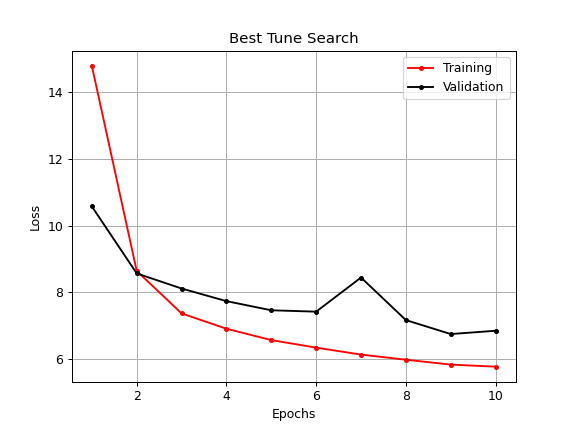

In [29]:
%matplotlib notebook
plot_loss(results["tune-from-scratch"]["training_losses"],
          results["tune-from-scratch"]["validation_losses"], "Best Tune Search")

In [28]:
predict_model(results["tune-from-scratch"]["model"], test_dataloader, "cuda:0", "tune_from_scratch_drive_predicted")

Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.46it/s]


'\nargs = {\n    "learning_rate": 0.01,\n    "unet_layers": "64-128-256",\n    "epochs": 10,\n    "batch_size": 64,\n    "scheduler": "CosineAnnealing",\n    "loss_function": "DiceLoss",\n    "dropout": 0.2\n}\n'